In [12]:
import sys
import numpy as np
import import_ipynb
import pandas as pd
from pathlib import Path
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_processing import matrices_assembly as assembly 
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Modules imports were successful!


# Project 3: Problem 3 (p33)

## Physics Constants

In [13]:
OMEGA = 2 * np.pi * 3E8
K0 = OMEGA * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Omega: {OMEGA:.3e} rad/s')
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Omega: 1.885e+09 rad/s
Wavelength: 0.9993 m
K0^2: 39.5331 1/m


## 3-noded Linear Triangular Elements, $P_1$

In [14]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'Free', 'value': None, 'name': 'inner_pml'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 301, 'name': 'PML_a','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 302, 'name': 'PML_b','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 303, 'name': 'PML_c','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 304, 'name': 'PML_d','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 401, 'name': 'PML_I','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 402, 'name': 'PML_II','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 403, 'name': 'PML_III','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 404, 'name': 'PML_IV','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

OMEGA_KEY = 'a'

OMEGA_C = {'a': {'h': WAVELENGTH, 'L': WAVELENGTH*0.5, 'ra': WAVELENGTH*0.5, 'x0': 1.0*WAVELENGTH}}

# Criar geometria coaxial
mesh_data = ps.create_domain_partial_pml(FINITE_ELEMENT, BOUNDARY, MATERIAL, OMEGA_KEY, n=1, view_mesh=False)

Malha salva em pre_processing/mesh/rectangular_pml_domain_Triangle1.msh
Model rectangular_pml (2D)
Info     : 51 geometric entities
Info     : 11 Physical Groups
Info     : 6316 nodes in total
Info     : 12249 2-D elements in total


## Figure 1: Meshed $\Omega_c$ domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


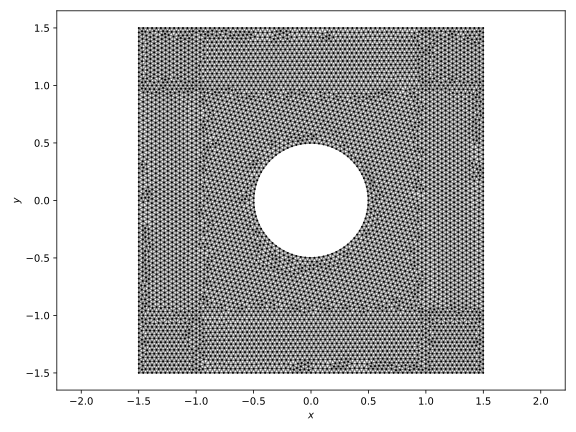

In [15]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

In [16]:
nodes_data = mesh_data['nodes']
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
dirichlet_nodes.keys()

dict_keys([17, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679])

## PML Project

In [17]:
# Determinação da Condutividade da PML
R_COEFFICIENT = 1E-4
SIGMA_0X = -np.log(R_COEFFICIENT) / WAVELENGTH

# Dimensões do domínio
x0 = OMEGA_C[OMEGA_KEY]['x0']
n = 1

# Dados da PML
pml_data = (SIGMA_0X, n, K0, x0)

## FEM Solution

In [18]:
# Montagem das matrizes globais
Sg, fg, Mg = assembly.global_matrices_pml(FINITE_ELEMENT, mesh_data, pml_data)

# Condições de contorno
Sg, fg = assembly.apply_simple_dirichlet(Sg, fg, mesh_data)

# Montagem da matriz global
Ag = Sg - Mg

# Solução do problema matricial
ezh = spsolve(Ag.tocsr(), fg.toarray())
ezh_dic = {key+1: value for key, value in enumerate(ezh)}

## Figure 2: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


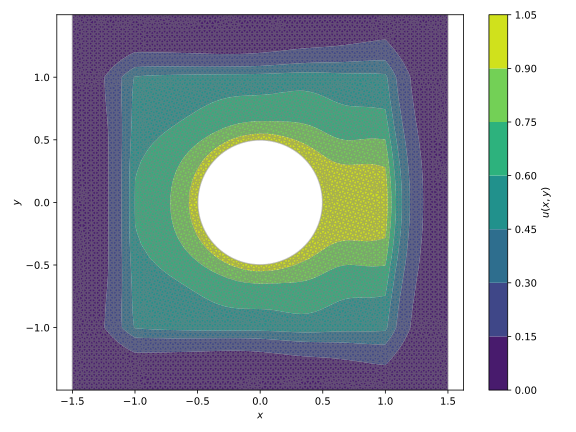

In [19]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, ezh_dic, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1_EntireDomain.svg"))

## Figure 3: Meshed Physical Domain, $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_physical_domain_Triangle1_EntireDomain.svg


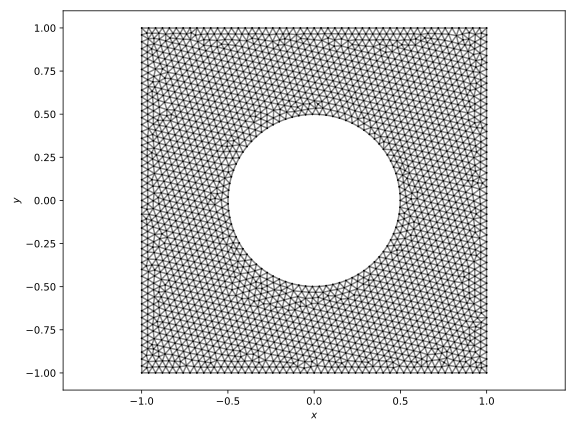

In [20]:
physical_mesh_data = ps.get_physical_mesh_data(mesh_data)
ps.plot_physical_mesh(FINITE_ELEMENT, mesh_data, physical_mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 4: Analytical Solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p33_circular_pec_scatterer_pml\pos_processing\pictures\analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg


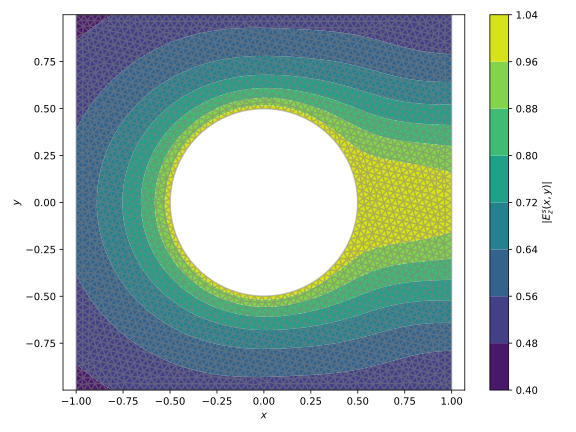

In [21]:
ez_phy = ps.solution_at_physical_domain(FINITE_ELEMENT, OMEGA_KEY, physical_mesh_data)
display(SVG(filename="pos_processing/pictures/analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 5: Numerical solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_at_physical_domain_Triangle1_EntireDomain.svg


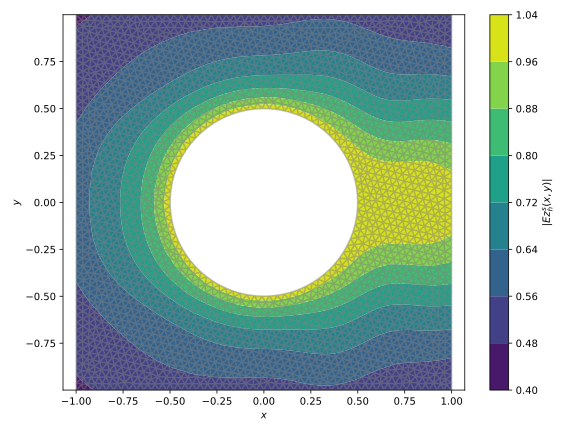

In [22]:
ezh_phy = ps.fem_solution_at_physical_domain(FINITE_ELEMENT, mesh_data, physical_mesh_data, ezh_dic)
display(SVG(filename="pos_processing/pictures/fem_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.